# Laptop Fiyat Tahmini  
&ensp;<sup>Edanur Yılmaz (121521014)</sup>  
&ensp;<sup>24.01.2025</sup>

## İçerik
• [Veri İncelemesi ve Ön İşlemesi](#Veri-İncelemesi-ve-Ön-İşlemesi)  
• [1.Multi-layer Perceptron Regressor](#1.Multi-layer-Perceptron-Regressor)    
    &emsp;- [Grid Search Cross-Validation](#1.1.Grid-Search-Cross-Validation)    
• [2.K-Nearest Neighbors Regressor](#2.K-Nearest-Neighbors-Regressor)  
    &emsp;- [Grid Search Cross-Validation](#2.1.Grid-Search-Cross-Validation)  
• [3.Random Forest Regressor](#3.Random-Forest-Regressor)    
    &emsp;- [Grid Search Cross-Validation](#3.1.Grid-Search-Cross-Validation)  
• [4.Gradient Boosting Regressor](#4.Gradient-Boosting-Regressor)  
    &emsp;- [Grid Search Cross-Validation](#4.1.Grid-Search-Cross-Validation)  
• [5.Extreme Gradient Boosting Regressor](#5.Extreme-Gradient-Boosting-Regressor)  
    &emsp;- [Grid Search Cross-Validation](#5.1.Grid-Search-Cross-Validation)

In [1]:
from warnings import filterwarnings
import pandas as pd
import numpy as np
import random
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFE
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

In [2]:
filterwarnings("ignore")

# Veri İncelemesi ve Ön İşlemesi
&ensp;<sup>[İçeriğe git.](#İçerik)</sup>

In [3]:
laptops_data = pd.read_csv("laptops.csv")

Laptop fiyatı tahmini yapacağım veri:

In [4]:
laptops_data.head()

,Laptop,Status,Brand,Model,CPU,RAM,Storage,Storage type,GPU,Screen,Touch,Final Price
0,ASUS ExpertBook B1 B1502CBA-EJ0436X Intel Core...,New,Asus,ExpertBook,Intel Core i5,8,512,SSD,NaN,15.6,No,1009.00
1,Alurin Go Start Intel Celeron N4020/8GB/256GB ...,New,Alurin,Go,Intel Celeron,8,256,SSD,NaN,15.6,No,299.00
2,ASUS ExpertBook B1 B1502CBA-EJ0424X Intel Core...,New,Asus,ExpertBook,Intel Core i3,8,256,SSD,NaN,15.6,No,789.00
3,MSI Katana GF66 12UC-082XES Intel Core i7-1270...,New,MSI,Katana,Intel Core i7,16,1000,SSD,RTX 3050,15.6,No,1199.00
4,HP 15S-FQ5085NS Intel Core i5-1235U/16GB/512GB...,New,HP,15S,Intel Core i5,16,512,SSD,NaN,15.6,No,669.01


In [5]:
laptops_data.dtypes

Laptop           object
Status           object
Brand            object
Model            object
CPU              object
RAM               int64
Storage           int64
Storage type     object
GPU              object
Screen          float64
Touch            object
Final Price     float64
dtype: object

In [6]:
def unique_value_count(variables):
    d = {}
    for variable in variables:
        d.update({variable: [laptops_data[variable].nunique()]})
        df = pd.DataFrame(d)
    return df

Kategorik değişkenlerin kaç çeşit değer alabildiğine bakıyorum.

In [7]:
variables = ["Status", "Brand", "Model", "CPU", "Storage type", "GPU", "Touch"]
unique_value_count(variables)

,Status,Brand,Model,CPU,Storage type,GPU,Touch
0,2,27,121,28,2,44,2


Çok sayıda değer alan değişkenleri çıkarıyorum. Dummy atanabilir ancak laptopa özgü hale geldiği için özellikle 'Model' gibi değişkenler anlamlı sonuçlar vermeyebilir.

In [8]:
remove = ["Laptop", "Brand", "Model", "CPU", "GPU"]
laptops_data.drop(remove, axis=1, inplace=True)
laptops_data

,Status,RAM,Storage,Storage type,Screen,Touch,Final Price
0,New,8,512,SSD,15.6,No,1009.00
1,New,8,256,SSD,15.6,No,299.00
2,New,8,256,SSD,15.6,No,789.00
3,New,16,1000,SSD,15.6,No,1199.00
4,New,16,512,SSD,15.6,No,669.01
...,...,...,...,...,...,...,...
2155,Refurbished,16,1000,SSD,17.3,No,2699.99
2156,Refurbished,16,1000,SSD,17.3,No,2899.99
2157,Refurbished,32,1000,SSD,17.3,No,3399.99
2158,Refurbished,16,1000,SSD,13.4,Yes,1899.99


Eksik değer var mı diye bakıyorum.

In [9]:
laptops_data.isnull().sum()

Status           0
RAM              0
Storage          0
Storage type    42
Screen           4
Touch            0
Final Price      0
dtype: int64

42 tane eksik gözlemi olan 'Storage type' değişkenini çıkarıyorum.  
(Çıkarmadan model kurduğumda feature importance'ı çok düşüktü.)

In [10]:
laptops_data.drop("Storage type", axis=1, inplace=True)

Kategorik değişkenlere değer atıyorum.

In [11]:
print(f"Status: {laptops_data["Status"].unique()}")

Status: ['New' 'Refurbished']


In [12]:
def Status_map(x):
    return x.map({"New" : 0,
                  "Refurbished" : 1})

In [13]:
laptops_data["Status"] = Status_map(laptops_data["Status"])

In [14]:
print(f"Touch: {laptops_data["Touch"].unique()}")

Touch: ['No' 'Yes']


In [15]:
def Touch_map(x):
    return x.map({"No" : 0,
                  "Yes" : 1})

In [16]:
laptops_data["Touch"] = Touch_map(laptops_data["Touch"])

'Screen' değişkeninin 4 tane eksik gözlemini, değişkenin ortalaması ile dolduruyorum.

In [17]:
laptops_data = laptops_data.apply(lambda x: x.fillna(x.mean()))
laptops_data

,Status,RAM,Storage,Screen,Touch,Final Price
0,0,8,512,15.6,0,1009.00
1,0,8,256,15.6,0,299.00
2,0,8,256,15.6,0,789.00
3,0,16,1000,15.6,0,1199.00
4,0,16,512,15.6,0,669.01
...,...,...,...,...,...,...
2155,1,16,1000,17.3,0,2699.99
2156,1,16,1000,17.3,0,2899.99
2157,1,32,1000,17.3,0,3399.99
2158,1,16,1000,13.4,1,1899.99


In [18]:
laptops_data.isnull().sum().sum()

0

In [19]:
laptops_data

,Status,RAM,Storage,Screen,Touch,Final Price
0,0,8,512,15.6,0,1009.00
1,0,8,256,15.6,0,299.00
2,0,8,256,15.6,0,789.00
3,0,16,1000,15.6,0,1199.00
4,0,16,512,15.6,0,669.01
...,...,...,...,...,...,...
2155,1,16,1000,17.3,0,2699.99
2156,1,16,1000,17.3,0,2899.99
2157,1,32,1000,17.3,0,3399.99
2158,1,16,1000,13.4,1,1899.99


In [20]:
laptops_data.describe()

,Status,RAM,Storage,Screen,Touch,Final Price
count,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000
mean,0.306481,15.413889,596.294444,15.168112,0.105093,1312.638509
std,0.461139,9.867815,361.220506,1.202214,0.306744,911.475417
min,0.000000,4.000000,0.000000,10.100000,0.000000,201.050000
25%,0.000000,8.000000,256.000000,14.000000,0.000000,661.082500
50%,0.000000,16.000000,512.000000,15.600000,0.000000,1031.945000
75%,1.000000,16.000000,1000.000000,15.600000,0.000000,1708.970000
max,1.000000,128.000000,4000.000000,18.000000,1.000000,7150.470000


Veriyi train ve test olarak ayırıyorum.

In [21]:
laptops_DF_train, laptops_DF_test = train_test_split(laptops_data,
                                         test_size=0.2,
                                         random_state=121521014)

'MinMax' ile ölçeklendiriyorum.

In [22]:
scaler = MinMaxScaler()

In [23]:
variables = list(laptops_DF_train.columns)

In [24]:
laptops_DF_train[variables] = scaler.fit_transform(laptops_DF_train[variables])
laptops_DF_test[variables] = scaler.transform(laptops_DF_test[variables])

In [25]:
laptops_DF_train.describe()

,Status,RAM,Storage,Screen,Touch,Final Price
count,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000
mean,0.309028,0.189390,0.149196,0.643857,0.100694,0.160345
std,0.462226,0.162832,0.092374,0.150918,0.301011,0.133870
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.066667,0.064000,0.493671,0.000000,0.064458
50%,0.000000,0.200000,0.128000,0.696203,0.000000,0.118585
75%,1.000000,0.200000,0.250000,0.696203,0.000000,0.219910
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [26]:
y_train_scaled = laptops_DF_train.pop("Final Price")
X_train_scaled = laptops_DF_train

In [27]:
y_test_scaled = laptops_DF_test.pop("Final Price")
X_test_scaled = laptops_DF_test

Denediğimde en iyi performans gösteren 5 modelin performanslarına bakıyorum.

# 1.Multi-layer Perceptron Regressor
&ensp;<sup>[İçeriğe git.](#İçerik)</sup>

In [28]:
aNN = MLPRegressor(random_state=121521014).fit(X_train_scaled, y_train_scaled)

Model tahminlerini alıyorum.

In [29]:
y_aNN_pred_train = aNN.predict(X_train_scaled)
y_aNN_pred_test = aNN.predict(X_test_scaled)

In [30]:
def RMSE(actual, predicted):
    MSE = mean_squared_error(actual, predicted)
    RMSE = np.sqrt(MSE)
    return RMSE

Modelin performansına bakmak için RMSE ve $R^2$ değerlerini buluyorum.

In [31]:
aNN_RMSE_train = RMSE(y_train_scaled, y_aNN_pred_train)
aNN_RMSE_test = RMSE(y_test_scaled, y_aNN_pred_test)
aNN_R2_train = r2_score(y_train_scaled, y_aNN_pred_train)
aNN_R2_test = r2_score(y_test_scaled, y_aNN_pred_test)

Tablo olarak göstermek için bir fonksiyon kullanıyorum.

In [32]:
def performance(train_RMSE, test_RMSE, train_R2, test_R2):
    performance = {"Train RMSE": [train_RMSE],
                   "Test RMSE": [test_RMSE],
                   "Train $R^2$": [train_R2],
                   "Test $R^2$": [test_R2]}
    df = pd.DataFrame(performance)
    return df

Test seti tahminlerinin daha iyi olduğu görülüyor. Train ve test tahminlerinin doğruluğu arasında büyük bir fark yok, bu iyi bir durum. 0'a yakın RMSE ve 62-64 arası $R^2$ değerleri ile modelin tahminlerinin iyi olduğunu ancak çok da başarılı olmadığını söyleyebilirim.

In [33]:
MLP = performance(aNN_RMSE_train, aNN_RMSE_test, aNN_R2_train, aNN_R2_test)
MLP = MLP.style.set_caption("MLPRegressor")
MLP

,Train RMSE,Test RMSE,Train $R^2$,Test $R^2$
0,0.081546,0.071413,0.628732,0.644027


#### 1.1.Grid Search Cross Validation
&nbsp;<sup>[İçeriğe git.](#İçerik)</sup>

MLPRegressor hiperparametrelerinden bazılarını belirliyorum.

In [34]:
#?aNN
aNN_params = {"alpha":[0.0001, 0.01, 0.1, 0.2],
              "hidden_layer_sizes":[(100,), (100,100)]}

In [35]:
aNNfCV = MLPRegressor(random_state=121521014)

En iyi parameterleri bulmak için 10 foldluk GridSearch yapıyorum.

In [36]:
aNN_CVGS = GridSearchCV(aNNfCV, aNN_params,
                        cv=10,
                        n_jobs=-1,
                        verbose=2).fit(X_train_scaled, y_train_scaled)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


In [37]:
aNN_CVGS.best_params_

{'alpha': 0.1, 'hidden_layer_sizes': (100, 100)}

En iyi olarak seçilen parametrelerle yeniden model kuruyorum.

In [38]:
aNN_CVGS_tuned = MLPRegressor(alpha=aNN_CVGS.best_params_["alpha"], 
                              hidden_layer_sizes=aNN_CVGS.best_params_["hidden_layer_sizes"]).fit(X_train_scaled, y_train_scaled)

Tahminleri alıyorum.

In [39]:
CVGS_pred_aNN_train = aNN_CVGS_tuned.predict(X_train_scaled)
CVGS_pred_aNN_test = aNN_CVGS_tuned.predict(X_test_scaled)

RMSE ve $R^2$ değerlerini buluyorum.

In [40]:
CVGS_aNN_RMSE_train = RMSE(y_train_scaled, CVGS_pred_aNN_train)
CVGS_aNN_RMSE_test = RMSE(y_test_scaled, CVGS_pred_aNN_test)
CVGS_aNN_R2_train = r2_score(y_train_scaled, CVGS_pred_aNN_train)
CVGS_aNN_R2_test = r2_score(y_test_scaled, CVGS_pred_aNN_test)

Modeli tune ettiğimizde performansın az da olsa arttığını görebiliyorum.

In [41]:
MLP

,Train RMSE,Test RMSE,Train $R^2$,Test $R^2$
0,0.081546,0.071413,0.628732,0.644027


In [42]:
CVGS_MLP = performance(CVGS_aNN_RMSE_train, CVGS_aNN_RMSE_test, CVGS_aNN_R2_train, CVGS_aNN_R2_test)
CVGS_MLP = CVGS_MLP.style.set_caption("CVGS Tuned MLPRegressor")
CVGS_MLP

,Train RMSE,Test RMSE,Train $R^2$,Test $R^2$
0,0.080478,0.070140,0.638392,0.656612


# 2.K-Nearest Neighbors Regressor
&nbsp;<sup>[İçeriğe git.](#İçerik)</sup>

Aynı işlemleri bu model için de yapıyorum.

In [43]:
kNN = KNeighborsRegressor().fit(X_train_scaled, y_train_scaled)

In [44]:
y_pred_kNN_train = kNN.predict(X_train_scaled)
y_pred_kNN_test = kNN.predict(X_test_scaled)

In [45]:
kNN_RMSE_train = RMSE(y_train_scaled, y_pred_kNN_train)
kNN_RMSE_test = RMSE(y_test_scaled, y_pred_kNN_test)
kNN_R2_train = r2_score(y_train_scaled, y_pred_kNN_train)
kNN_R2_test = r2_score(y_test_scaled, y_pred_kNN_test)

Bu modelin MLPRegressor'dan daha iyi performan gösterdiğini söyleyebilirim. Train seti için Test setinden daha iyi performans gösterse de arada çok büyük bir fark yok.

In [46]:
KNeighbors = performance(kNN_RMSE_train, kNN_RMSE_test, kNN_R2_train, kNN_R2_test)
KNeighbors = KNeighbors.style.set_caption("KNeighborsRegressor")
KNeighbors

,Train RMSE,Test RMSE,Train $R^2$,Test $R^2$
0,0.076265,0.070936,0.675258,0.648775


#### 2.1.Grid Search Cross Validation
&nbsp;<sup>[İçeriğe git.](#İçerik)</sup>

KNeighborsRegressor hiperparametrelerinden bazılarını belirliyorum.

In [47]:
#?kNN
kNN_params = {"n_neighbors":np.arange(20,30,1),
              "weights": ['uniform', 'distance']}

In [48]:
kNNfCV = KNeighborsRegressor()

En iyi parameterleri bulmak için 10 foldluk bir GridSearch yapıyorum.

In [49]:
kNN_CVGS = GridSearchCV(kNNfCV, 
                        kNN_params,
                        cv=10,
                        n_jobs=-1,
                        verbose=2).fit(X_train_scaled, y_train_scaled)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


In [50]:
kNN_CVGS.best_params_

{'n_neighbors': 29, 'weights': 'distance'}

En iyi olarak seçilen parametrelerle yeniden model kuruyorum.

In [51]:
kNN_CVGS_tuned = KNeighborsRegressor(n_neighbors=kNN_CVGS.best_params_["n_neighbors"],
                                     weights=kNN_CVGS.best_params_["weights"]).fit(X_train_scaled,y_train_scaled)

Tahminleri alıyorum.

In [52]:
CVGS_pred_kNN_train = kNN_CVGS_tuned.predict(X_train_scaled)
CVGS_pred_kNN_test = kNN_CVGS_tuned.predict(X_test_scaled)

RMSE ve $R^2$ değerlerini buluyorum.

In [53]:
CVGS_kNN_RMSE_train = RMSE(y_train_scaled, CVGS_pred_kNN_train)
CVGS_kNN_RMSE_test = RMSE(y_test_scaled, CVGS_pred_kNN_test)
CVGS_kNN_R2_train = r2_score(y_train_scaled, CVGS_pred_kNN_train)
CVGS_kNN_R2_test = r2_score(y_test_scaled, CVGS_pred_kNN_test)

Performansın, Train seti için dikkate değer miktarda azaldığını fakat Test seti için az da olsa arttığını görebiliyorum.

In [54]:
KNeighbors

,Train RMSE,Test RMSE,Train $R^2$,Test $R^2$
0,0.076265,0.070936,0.675258,0.648775


In [55]:
CVGS_KNN = performance(CVGS_aNN_RMSE_train, CVGS_aNN_RMSE_test, CVGS_aNN_R2_train, CVGS_aNN_R2_test)
CVGS_KNN = CVGS_KNN.style.set_caption("CVGS Tuned KNeighborsRegressor")
CVGS_KNN

,Train RMSE,Test RMSE,Train $R^2$,Test $R^2$
0,0.080478,0.070140,0.638392,0.656612


(Random Forest ve sonrasında gelen modeller için ölçeklendirilmiş verinin gerek olmadığını biliyorum fakat aynı setlerle devam ettim.)

# 3.Random Forest Regressor
&ensp;<sup>[İçeriğe git.](#İçerik)</sup>

In [56]:
RndF = RandomForestRegressor(random_state=121521014).fit(X_train_scaled, y_train_scaled)

In [57]:
def feature_importances(title, model, X):
    feature_imp = pd.Series(model.feature_importances_,
                        index=X.columns).sort_values(ascending=False)
    
    sns.barplot(x=feature_imp, y=feature_imp.index, palette='colorblind')
    plt.xlabel('Değişken Önem Skorları')
    plt.ylabel('Değişkenler')
    plt.title(title)
    return plt.show()

Random Forest modeli için değişkenlerin önemliliklerine bakıyorum.

Modelde en etkili değişkenin 'Storage' ve en önemsiz değişkenin ise 'Touch' olduğunu görebiliyorum.

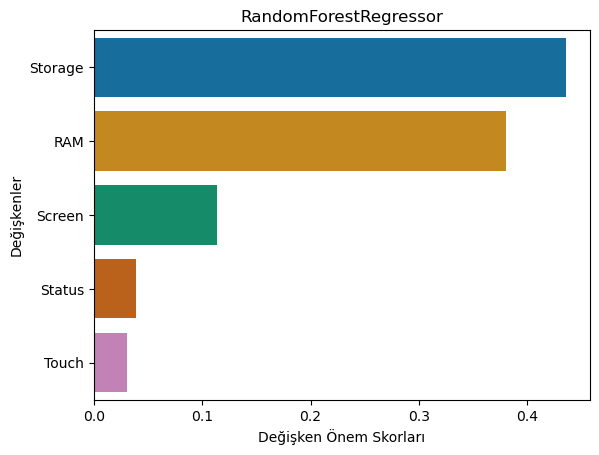

In [58]:
RndF_features = feature_importances("RandomForestRegressor", RndF, X_train_scaled)

Tahminleri alıyorum.

In [59]:
RndF_y_pred_train = RndF.predict(X_train_scaled)
RndF_y_pred_test = RndF.predict(X_test_scaled)

RMSE ve $R^2$ değerlerini buluyorum.

In [60]:
RndF_RMSE_train = RMSE(y_train_scaled, RndF_y_pred_train)
RndF_RMSE_test = RMSE(y_test_scaled,RndF_y_pred_test)
RndF_R2_train = r2_score(y_train_scaled, RndF_y_pred_train)
RndF_R2_test = r2_score(y_test_scaled, RndF_y_pred_test)

Performansı önceki iki modelden daha iyi. Train seti tahminleri Test setinden daha iyi fakat çok büyük bir fark yok.

In [61]:
RandomForest = performance(RndF_RMSE_train, RndF_RMSE_test, RndF_R2_train, RndF_R2_test)
RandomForest = RandomForest.style.set_caption("RandomForestRegressor")
RandomForest

,Train RMSE,Test RMSE,Train $R^2$,Test $R^2$
0,0.068266,0.068727,0.739806,0.670302


#### 3.1.Grid Search Cross Validation
&nbsp;<sup>[İçeriğe git.](#İçerik)</sup>

RandomForestRegressor hiperparametrelerinden bazılarını belirliyorum.

In [62]:
#?RndF
RndF_params = {"max_features" : ["sqrt", "log2", None],
               "n_estimators": [100, 500, 800]}

In [63]:
RndFfCV = RandomForestRegressor(random_state=121521014)

En iyi parameterleri bulmak için 10 foldluk bir GridSearch yapıyorum.

In [71]:
RndF_CVGS = GridSearchCV(RndFfCV, RndF_params, 
                         cv=20,
                         n_jobs=-1,
                         verbose=2).fit(X_train_scaled, y_train_scaled)

Fitting 20 folds for each of 9 candidates, totalling 180 fits


In [72]:
RndF_CVGS.best_params_

{'max_features': 'sqrt', 'n_estimators': 100}

En iyi olarak seçilen parametrelerle yeniden model kuruyorum.

In [73]:
RndF_CVGS_tuned = RandomForestRegressor(max_features = RndF_CVGS.best_params_["max_features"],
                                                       n_estimators = RndF_CVGS.best_params_["n_estimators"]).fit(X_train_scaled, y_train_scaled)

Tahminleri alıyorum.

In [74]:
CVGS_pred_RndF_train = RndF_CVGS_tuned.predict(X_train_scaled)
CVGS_pred_RndF_test = RndF_CVGS_tuned.predict(X_test_scaled)

RMSE ve $R^2$ değerlerini buluyorum.

In [75]:
CVGS_RndF_RMSE_train = RMSE(y_train_scaled, CVGS_pred_RndF_train)
CVGS_RndF_RMSE_test = RMSE(y_test_scaled, CVGS_pred_RndF_test)
CVGS_RndF_R2_train = r2_score(y_train_scaled, CVGS_pred_RndF_train)
CVGS_RndF_R2_test = r2_score(y_test_scaled, CVGS_pred_RndF_test)

Tune edilmiş modelin performansı çok az da olsa iyileştirdiğini görüyorum.

In [76]:
RandomForest

,Train RMSE,Test RMSE,Train $R^2$,Test $R^2$
0,0.068266,0.068727,0.739806,0.670302


In [77]:
CVGS_RndF = performance(CVGS_RndF_RMSE_train, CVGS_RndF_RMSE_test, CVGS_RndF_R2_train, CVGS_RndF_R2_test)
CVGS_RndF = CVGS_RndF.style.set_caption("CVGS Tuned RandomForestRegressor")
CVGS_RndF

,Train RMSE,Test RMSE,Train $R^2$,Test $R^2$
0,0.068128,0.068643,0.740860,0.671108


# 4.Gradient Boosting Regressor
&nbsp;<sup>[İçeriğe git.](#İçerik)</sup>

In [78]:
gBR = GradientBoostingRegressor(random_state=121521014).fit(X_train_scaled, y_train_scaled)

Gradient Boosting modeli için değişkenlerin önemliliklerine bakıyorum. Random Forest'la oldukça benzer.

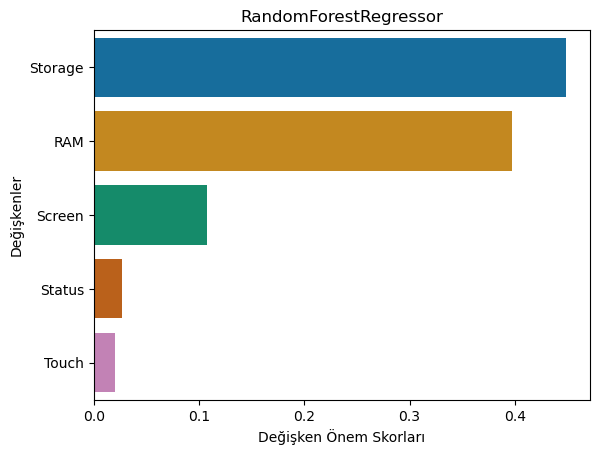

In [79]:
gBR_features = feature_importances("RandomForestRegressor", gBR, X_train_scaled)

Tahminleri alıyorum.

In [80]:
gBR_y_pred_train = gBR.predict(X_train_scaled)
gBR_y_pred_test = gBR.predict(X_test_scaled)

RMSE ve $R^2$ değerlerini buluyorum.

In [81]:
gBR_RMSE_train = RMSE(y_train_scaled, gBR_y_pred_train)
gBR_RMSE_test = RMSE(y_test_scaled,gBR_y_pred_test)
gBR_R2_train = r2_score(y_train_scaled, gBR_y_pred_train)
gBR_R2_test = r2_score(y_test_scaled, gBR_y_pred_test)

Train seti performansı, Test setinden daha iyi fakat büyük bir fark yok. 

In [82]:
GradientBoosting = performance(gBR_RMSE_train, gBR_RMSE_test, gBR_R2_train, gBR_R2_test)
GradientBoosting = GradientBoosting.style.set_caption("GradientBoostingRegressor")
GradientBoosting

,Train RMSE,Test RMSE,Train $R^2$,Test $R^2$
0,0.071933,0.065426,0.711104,0.701212


#### 4.1.Grid Search Cross Validation
&nbsp;<sup>[İçeriğe git.](#İçerik)</sup>

GradientBoostingRegressor hiperparametrelerinden bazılarını belirliyorum.

In [83]:
#?gBR
gBR_params = {"learning_rate": [0.001, 0.1, 0.2],
              "max_depth": [3, 4, 5],
              "subsample": [0.5, 0.8, 1]}

In [84]:
gBRfCV = GradientBoostingRegressor(random_state=121521014)

En iyi parameterleri bulmak için 10 foldluk bir GridSearch yapıyorum.

In [85]:
gBR_CVGS = GridSearchCV(gBRfCV, gBR_params, 
                        cv=10,
                        n_jobs=-1,
                        verbose=2).fit(X_train_scaled, y_train_scaled)

Fitting 10 folds for each of 27 candidates, totalling 270 fits


In [86]:
gBR_CVGS.best_params_

{'learning_rate': 0.1, 'max_depth': 4, 'subsample': 1}

En iyi olarak seçilen parametrelerle yeniden model kuruyorum.

In [88]:
gBR_CVGS_tuned = GradientBoostingRegressor(learning_rate = gBR_CVGS.best_params_["learning_rate"],
                                           max_depth = gBR_CVGS.best_params_["max_depth"],
                                           subsample = gBR_CVGS.best_params_["subsample"]).fit(X_train_scaled, y_train_scaled)

Tahminleri alıyorum.

In [89]:
CVGS_pred_gBR_train = gBR_CVGS_tuned.predict(X_train_scaled)
CVGS_pred_gBR_test = gBR_CVGS_tuned.predict(X_test_scaled)

RMSE ve $R^2$ değerlerini buluyorum.

In [90]:
CVGS_gBR_RMSE_train = RMSE(y_train_scaled, CVGS_pred_gBR_train)
CVGS_gBR_RMSE_test = RMSE(y_test_scaled, CVGS_pred_gBR_test)
CVGS_gBR_R2_train = r2_score(y_train_scaled, CVGS_pred_gBR_train)
CVGS_gBR_R2_test = r2_score(y_test_scaled, CVGS_pred_gBR_test)

Tune edilmiş modelin performansı çok az da olsa iyileştirdiğini görüyorum.

In [91]:
GradientBoosting

,Train RMSE,Test RMSE,Train $R^2$,Test $R^2$
0,0.071933,0.065426,0.711104,0.701212


In [92]:
CVGS_gBR = performance(CVGS_gBR_RMSE_train, CVGS_gBR_RMSE_test, CVGS_gBR_R2_train, CVGS_gBR_R2_test)
CVGS_gBR = CVGS_gBR.style.set_caption("CVGS Tuned GradientBoostingRegressor")
CVGS_gBR

,Train RMSE,Test RMSE,Train $R^2$,Test $R^2$
0,0.069940,0.065331,0.726888,0.702079


# 5.Extreme Gradient Boosting Regressor
&ensp;<sup>[İçeriğe git.](#İçerik)</sup>

In [93]:
xgBR = XGBRegressor(random_state=121521014).fit(X_train_scaled, y_train_scaled)

Tahminleri alıyorum.

In [94]:
xgBR_y_pred_train = xgBR.predict(X_train_scaled)
xgBR_y_pred_test = xgBR.predict(X_test_scaled)

RMSE ve $R^2$ değerlerini buluyorum.

In [95]:
xgBR_RMSE_train = RMSE(y_train_scaled, xgBR_y_pred_train)
xgBR_RMSE_test = RMSE(y_test_scaled, xgBR_y_pred_test)
xgBR_R2_train = r2_score(y_train_scaled, xgBR_y_pred_train)
xgBR_R2_test = r2_score(y_test_scaled, xgBR_y_pred_test)

Train seti performansı, Test setinden daha iyi fakat çok büyük bir fark yok.

In [96]:
XGB = performance(xgBR_RMSE_train, xgBR_RMSE_test, xgBR_R2_train, xgBR_R2_test)
XGB = XGB.style.set_caption("XGBRegressor")
XGB

,Train RMSE,Test RMSE,Train $R^2$,Test $R^2$
0,0.067787,0.068296,0.743445,0.674426


#### 5.1.Grid Search Cross Validation
&nbsp;<sup>[İçeriğe git.](#İçerik)</sup>

XGBRegressor hiperparametrelerinden bazılarını belirliyorum.

In [97]:
#?xgBR
xgBR_params = {"learning_rate": [0.01, 0.1, 0.2],
               "max_depth": [3, 4, 5],
               "subsample": [0.5, 0.8, 1]}

In [98]:
xgBRfCV = XGBRegressor(random_state=121521014)

En iyi parameterleri bulmak için 10 foldluk bir GridSearch yapıyorum.

In [123]:
xgBR_CVGS = GridSearchCV(xgBRfCV, xgBR_params, 
                        cv=10,
                        n_jobs=-1,
                        verbose=2).fit(X_train_scaled, y_train_scaled)

Fitting 10 folds for each of 27 candidates, totalling 270 fits


In [124]:
xgBR_CVGS.best_params_

{'learning_rate': 0.1, 'max_depth': 4, 'subsample': 1}

En iyi olarak seçilen parametrelerle yeniden model kuruyorum.

In [125]:
xgBR_CVGS_tuned = XGBRegressor(learning_rate = xgBR_CVGS.best_params_["learning_rate"],
                               max_depth = xgBR_CVGS.best_params_["max_depth"],
                               subsample = xgBR_CVGS.best_params_["subsample"]).fit(X_train_scaled, y_train_scaled)

Tahminleri alıyorum.

In [126]:
CVGS_pred_xgBR_train = xgBR_CVGS_tuned.predict(X_train_scaled)
CVGS_pred_xgBR_test = xgBR_CVGS_tuned.predict(X_test_scaled)

RMSE ve $R^2$ değerlerini buluyorum.

In [127]:
CVGS_xgBR_RMSE_train = RMSE(y_train_scaled, CVGS_pred_xgBR_train)
CVGS_xgBR_RMSE_test = RMSE(y_test_scaled, CVGS_pred_xgBR_test)
CVGS_xgBR_R2_train = r2_score(y_train_scaled, CVGS_pred_xgBR_train)
CVGS_xgBR_R2_test = r2_score(y_test_scaled, CVGS_pred_xgBR_test)

Train seti performansı azalırken, Test seti performansı arttı.

In [128]:
XGB

,Train RMSE,Test RMSE,Train $R^2$,Test $R^2$
0,0.067787,0.068296,0.743445,0.674426


In [129]:
CVGS_xgBR = performance(CVGS_xgBR_RMSE_train, CVGS_xgBR_RMSE_test, CVGS_xgBR_R2_train, CVGS_xgBR_R2_test)
CVGS_xgBR = CVGS_xgBR.style.set_caption("CVGS Tuned XGBRegressor")
CVGS_xgBR

,Train RMSE,Test RMSE,Train $R^2$,Test $R^2$
0,0.070332,0.065208,0.723822,0.703206


Tune edilmiş Extreme Gradient Boosting Regressor ve çok yakın bir performansa sahip tune edilmiş Gradient Boosting Regressor modellerinin en iyi performansa sahip olduğunu söyleyebilirim.  
İki modelin de test seti için ilişkiyi yaklaşık %70 kadar açıklayabildiğini görüyorum.

-------------------------------------------------------------------------------------------------------

1.

In [106]:
MLP

,Train RMSE,Test RMSE,Train $R^2$,Test $R^2$
0,0.081546,0.071413,0.628732,0.644027


In [107]:
CVGS_MLP

,Train RMSE,Test RMSE,Train $R^2$,Test $R^2$
0,0.080478,0.070140,0.638392,0.656612


2.

In [108]:
KNeighbors

,Train RMSE,Test RMSE,Train $R^2$,Test $R^2$
0,0.076265,0.070936,0.675258,0.648775


In [109]:
CVGS_KNN

,Train RMSE,Test RMSE,Train $R^2$,Test $R^2$
0,0.080478,0.070140,0.638392,0.656612


3.

In [110]:
RandomForest

,Train RMSE,Test RMSE,Train $R^2$,Test $R^2$
0,0.068266,0.068727,0.739806,0.670302


In [111]:
CVGS_RndF

,Train RMSE,Test RMSE,Train $R^2$,Test $R^2$
0,0.068128,0.068643,0.740860,0.671108


4.

In [112]:
GradientBoosting

,Train RMSE,Test RMSE,Train $R^2$,Test $R^2$
0,0.071933,0.065426,0.711104,0.701212


In [113]:
CVGS_gBR

,Train RMSE,Test RMSE,Train $R^2$,Test $R^2$
0,0.069940,0.065331,0.726888,0.702079


5.

In [114]:
XGB

,Train RMSE,Test RMSE,Train $R^2$,Test $R^2$
0,0.067787,0.068296,0.743445,0.674426


In [130]:
CVGS_xgBR

,Train RMSE,Test RMSE,Train $R^2$,Test $R^2$
0,0.070332,0.065208,0.723822,0.703206
